<a id="top"></a>
# Landsat Vegetation Phenology

<hr>

*Notebook compatible with DE Africa Collection 1 Sandbox

# Notebook Summary

This notebook calculates vegetation phenology changes using Landsat 7 or Landsat 8 data. To detect changes in plant life for Landsat, the algorithm uses either the Normalized Difference Vegetation Index (NDVI) or the Enhanced Vegetation Index (EVI), which are common proxies for vegetation growth and health. The outputs of this notebook can be used to assess differences in agriculture fields over time or space and also allow the assessment of growing states such as planting and harvesting.  
<br>
There are two output products. The first output product is a time series boxplot of NDVI or EVI with the data potentially binned by week, month, week of year, or month of year. The second output product is a time series lineplot of the mean NDVI or EVI for each year, with the data potentially binned by week or month. This product is useful for comparing years to each other.
<br><br>
See this website for more information: https://phenology.cr.usgs.gov/ndvi_foundation.php

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platforms and Products](#plat_prod)
* [Define the Extents of the Analysis](#define_extents)
* [Load Data from the Data Cube and Obtain the Vegetation Proxy](#load_data)
* [Create Phenology Products](#phenology_products)
    * [Plot the Vegetation Index Over Time in a Box-and-Whisker Plot](#phenology_plot_1)
    * [Plot the Vegetation Index Over Time for Each Year](#phenology_plot_2)
* [Export Curve Fits to a CSV File](#export)
* [Show TIMESAT Stats](#timesat)

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span> 

In [1]:
import datacube
import sys
import os

# Supress Warnings.
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from odc.ui import DcViewer
from datacube.helpers import write_geotiff


#import DE Africa script
sys.path.append('../../Scripts')
from deafrica_plotting import display_map
from deafrica_plotting import rgb


#import DCAL utility scripts
sys.path.append('../DCAL_utils')
from clean_mask import landsat_qa_clean_mask, landsat_clean_mask_invalid
from sort import xarray_sortby_coord
from vegetation import NDVI, EVI
from plotter_utils import xarray_time_series_plot

### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="DCAL Vegitation Phenology")

## View Extent of Avalible Data

In [3]:
# Get available products
products_info = dc.list_products()

# List Landsat 8 products
print("Landsat 8 Products:")
products_info[["platform", "name"]]

Landsat 8 Products:


,platform,name
id,,
14,ALOS/ALOS-2,alos_palsar_mosaic
17,None,ga_ls8c_gm_2_annual
15,None,ga_ls8c_wofs_2
13,None,ga_ls8c_wofs_2_annual_summary
16,None,ga_ls8c_wofs_2_summary
3,LANDSAT_5,ls5_usgs_sr_scene
2,LANDSAT_7,ls7_usgs_sr_scene
1,LANDSAT_8,ls8_usgs_sr_scene
6,None,ls_usgs_fc_scene


In [4]:
DcViewer(dc=dc,
         products = ['ls8_usgs_sr_scene'],
         time='2017',
         center=(0.565, 38.007),
         zoom=4)

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [5]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)

# Tanzania Grassland / Cropland
# lat = (-4.5074, -4.4860) # North of Swaga Game Reserve
# lon = (35.1349, 35.1735) # North of Swaga Game Reserve

# Tanzania Grassland / Cropland
# lat = (-8.1541, -8.1272) # Southern Cropland 
# lon = (33.2016, 33.2545) # Southern Cropland

# Aviv Coffee Farm, Tanzania (small)
# lat = (-10.6999, -10.6959) 
# lon = (35.2608, 35.2662) 

# Aviv Coffee Farm, Tanzania (surrounding)
# lat = (-10.855, -10.560)
# lon = (35.130, 35.400)

# Soybean Fields in Western Kenya (from Kizito)
# lat = (-0.801180, -0.483689) # entire region
# lon = (34.193792, 34.546329) # entire region

# Ghana
latitude = (5.5813, 5.6004)
longitude = (-0.5398, -0.5203)

# Time Period
start_date, end_date = dt.datetime(2013,1,1), dt.datetime(2018,12,31)
time_extents = (start_date, end_date)

**Visualize the selected area**

In [6]:
display_map(longitude,latitude)

## <span id="load_data">Load Data from the Data Cube and Obtain the Vegetation Proxy [&#9652;](#top)</span>

## Select Vegetation Proxy

Change which line is commented out in order to switch vegitation proxy. NDVI is the recomended Vegitation Proxy

In [7]:
veg_proxy = 'NDVI'

once proxy is selected load data and mask out cloud

In [8]:
measurements = []
if veg_proxy == 'NDVI':
    measurements = ['red', 'nir', 'pixel_qa']
elif veg_proxy == 'EVI':
    measurements = ['red', 'blue', 'nir', 'pixel_qa']


landsat_dataset = dc.load(product = 'ls8_usgs_sr_scene',
                          measurements = measurements,
                          y = latitude,
                          x = longitude,
                          time = time_extents,
                          output_crs='EPSG:6933',
                          resolution=(-30,30))

#load cloud mask and apply to dataset
cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform='LANDSAT_8')
dataset = landsat_dataset.where(cloud_mask)

#view masked dataset
dataset

<xarray.Dataset>
Dimensions:   (time: 102, x: 64, y: 82)
Coordinates:
  * time      (time) datetime64[ns] 2013-04-20T10:17:29.521651 ... 2017-12-27T10:15:52.569447
  * y         (y) float64 7.134e+05 7.133e+05 7.133e+05 ... 7.11e+05 7.109e+05
  * x         (x) float64 -5.21e+04 -5.206e+04 ... -5.024e+04 -5.020e+04
Data variables:
    red       (time, y, x) float64 nan nan nan ... 1.092e+03 1.002e+03 1.011e+03
    nir       (time, y, x) float64 nan nan nan ... 2.868e+03 2.917e+03 2.909e+03
    pixel_qa  (time, y, x) float64 nan nan nan nan ... 322.0 322.0 322.0 322.0
Attributes:
    crs:      EPSG:6933

In [9]:
#change Coordinate names to be compatible with modules used latter in this notebook
dataset = dataset.rename(name_dict={'x':'longitude','y':'latitude'})

dataset

<xarray.Dataset>
Dimensions:    (latitude: 82, longitude: 64, time: 102)
Coordinates:
  * time       (time) datetime64[ns] 2013-04-20T10:17:29.521651 ... 2017-12-27T10:15:52.569447
  * latitude   (latitude) float64 7.134e+05 7.133e+05 ... 7.11e+05 7.109e+05
  * longitude  (longitude) float64 -5.21e+04 -5.206e+04 ... -5.020e+04
Data variables:
    red        (time, latitude, longitude) float64 nan nan ... 1.011e+03
    nir        (time, latitude, longitude) float64 nan nan ... 2.909e+03
    pixel_qa   (time, latitude, longitude) float64 nan nan nan ... 322.0 322.0
Attributes:
    crs:      EPSG:6933

In [10]:
#Generate CHosen Vegitation Proxy
if veg_proxy == 'NDVI':
    dataset[veg_proxy] = NDVI(dataset)
if veg_proxy == 'EVI':
    dataset[veg_proxy] = EVI(dataset)
    
dataset

<xarray.Dataset>
Dimensions:    (latitude: 82, longitude: 64, time: 102)
Coordinates:
  * time       (time) datetime64[ns] 2013-04-20T10:17:29.521651 ... 2017-12-27T10:15:52.569447
  * latitude   (latitude) float64 7.134e+05 7.133e+05 ... 7.11e+05 7.109e+05
  * longitude  (longitude) float64 -5.21e+04 -5.206e+04 ... -5.020e+04
Data variables:
    red        (time, latitude, longitude) float64 nan nan ... 1.011e+03
    nir        (time, latitude, longitude) float64 nan nan ... 2.909e+03
    pixel_qa   (time, latitude, longitude) float64 nan nan nan ... 322.0 322.0
    NDVI       (time, latitude, longitude) float64 nan nan nan ... 0.4886 0.4842
Attributes:
    crs:      EPSG:6933

## <span id="phenology_products">Create Phenology Products[&#9652;](#top)</span>

If no plots appear in the figures below, there is no data available for the region selected.

### <span id="phenology_plot_1">Plot the Vegetation Index Over Time in a Box-and-Whisker Plot[&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [11]:
# Specify whether to plot a curve fit of the vegetation index along time. Input can be either TRUE or FALSE
plot_curve_fit = True
assert isinstance(plot_curve_fit, bool), "The variable 'plot_curve_fit' must be "\
                                         "either True or False."

# Specify the target aggregation type of the curve fit. Input can be either 'mean' or 'median'.
curve_fit_target = 'median'
assert curve_fit_target in ['mean', 'median'], "The variable 'curve_fit_target' must be either "\
                                               "'mean' or 'median'."

# The maximum number of data points that appear along time in each plot.
# If more than this number of data points need to be plotted, a grid of plots will be created.
max_times_per_plot = 40 

<p style="color:red";><b>CHANGE INPUTS BELOW

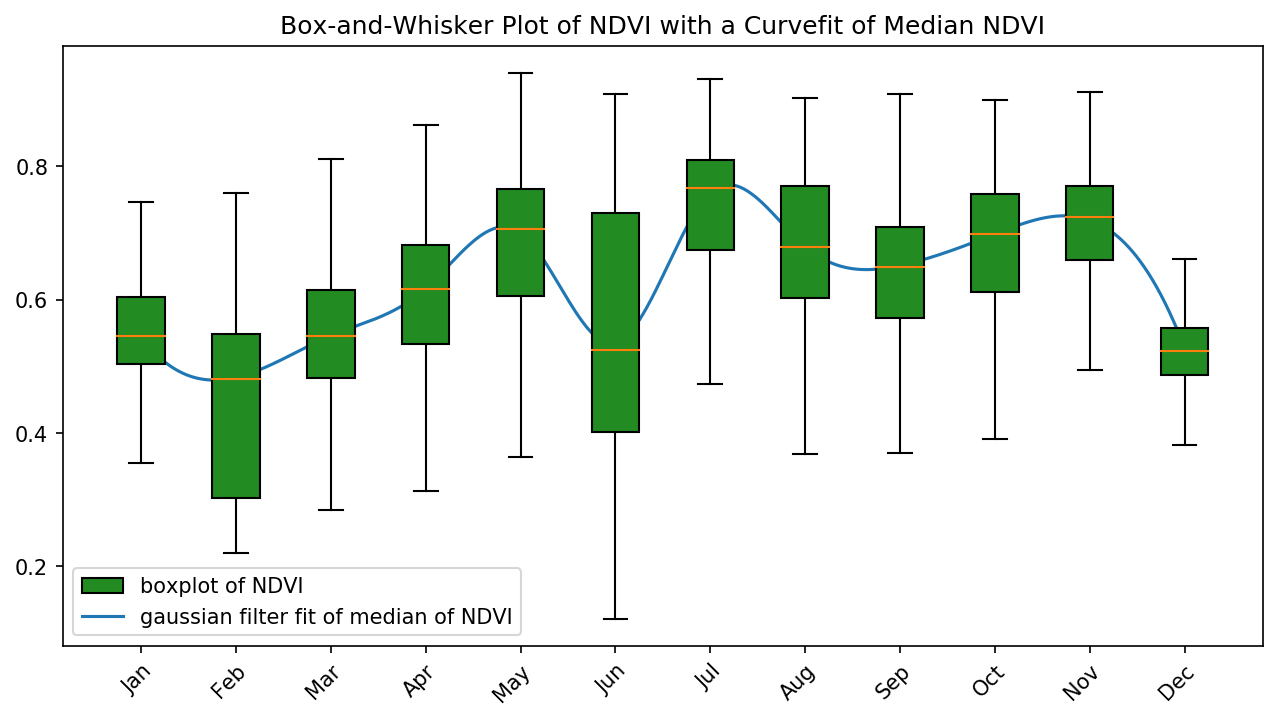

In [12]:
# Select the binning approach for the vegetation index. Set the 'bin_by' parameter.
# None          = do not bin the data
# 'week'        = bin the data by week with an extended time axis
# 'month'       = bin the data by month with an extended time axis
# 'weekofyear'  = bin the data by week and years using a single year time axis
# 'monthofyear' = bin the data by month and years using a single year time axis

# It is also possible to change some of the plotting features using the code below.

bin_by = 'monthofyear'
assert bin_by in [None, 'week', 'month', 'weekofyear', 'monthofyear'], \
    "The variable 'bin_by' can only have one of these values: "\
    "[None, 'week', 'month', 'weekofyear', 'monthofyear']"

aggregated_by_str = None
if bin_by is None:
    plotting_data = dataset
elif bin_by == 'week':
    plotting_data = dataset.resample(time='1w').mean()
    aggregated_by_str = 'Week'
elif bin_by == 'month':
    plotting_data = dataset.resample(time='1m').mean()
    aggregated_by_str = 'Month'
elif bin_by == 'weekofyear':
    plotting_data = dataset.groupby('time.week').mean(dim=('time'))
    aggregated_by_str = 'Week of Year'
elif bin_by == 'monthofyear':
    plotting_data = dataset.groupby('time.month').mean(dim=('time'))
    aggregated_by_str = 'Month of Year'
    
params = dict(dataset=plotting_data, plot_descs={veg_proxy:{'none':[
    {'box':{'boxprops':{'facecolor':'forestgreen'}}}]}})
if plot_curve_fit:
    params['plot_descs'][veg_proxy][curve_fit_target] = [{'gaussian_filter':{}}]
    
xarray_time_series_plot(**params, fig_params=dict(figsize=(8,4), dpi=150), 
                        max_times_per_plot=max_times_per_plot)
plt.title('Box-and-Whisker Plot of {0} with a Curvefit of Median {0}'.format(veg_proxy))
plt.show()

### <span id="phenology_plot_2">Plot the Vegetation Index Over Time for Each Year[&#9652;](#top)</span>
Note that the curve fits here do not show where some times have no data (encoded as NaNs), as is shown in the box-and-whisker plot. Notably, the curve fits interpolate over times with missing data that are not the first or last time (e.g. January or December for monthly binned data).

<p style="color:red";><b>CHANGE INPUTS BELOW

Year 2018 has no data, so will not be plotted.


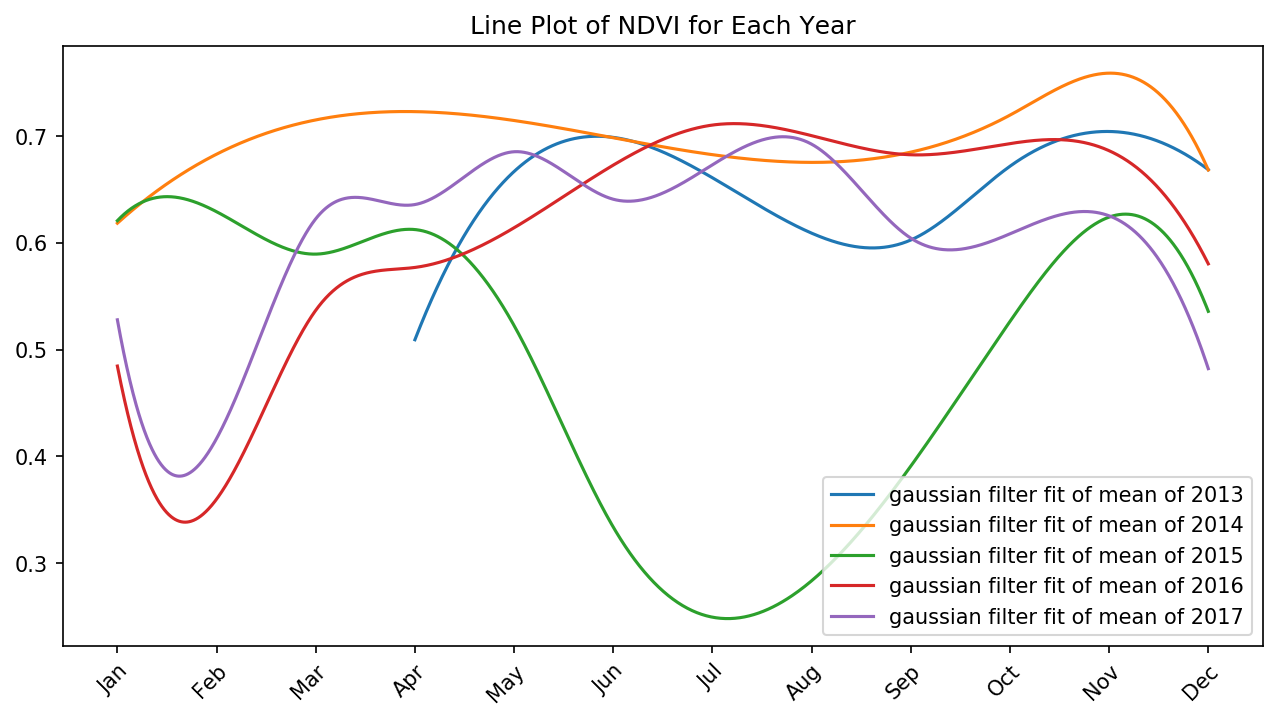

In [13]:
years_with_data = []
plot_descs = {}
daysofyear_per_year = {}
plotting_data_years = {}
time_dim_name = None
for year in range(start_date.year, end_date.year+1):
    year_data = dataset.sel(time=slice('{}-01-01'.format(year), '{}-12-31'.format(year)))[veg_proxy]
    if len(year_data['time']) == 0: # There is nothing to plot for this year.
        print("Year {} has no data, so will not be plotted.".format(year))
        continue
    years_with_data.append(year)
    
    spec_ind_dayofyear = year_data.groupby('time.dayofyear').mean()
    daysofyear_per_year[year] = spec_ind_dayofyear[~spec_ind_dayofyear.isnull()].dayofyear
    
# Select the binning approach for the vegetation index. Set the 'bin_by' parameter.
# 'weekofyear'  = bin the data by week and years using a single year time axis
# 'monthofyear' = bin the data by month and years using a single year time axis

    bin_by = 'monthofyear'
    
    assert bin_by in ['weekofyear', 'monthofyear'], \
        "The variable 'bin_by' can only have one of these values: "\
        "['weekofyear', 'monthofyear']"
    
    aggregated_by_str = None
    if bin_by == 'weekofyear':
        plotting_data_year = year_data.groupby('time.week').mean(dim=('time'))
        time_dim_name = 'week'
    elif bin_by == 'monthofyear':
        plotting_data_year = year_data.groupby('time.month').mean(dim=('time'))
        time_dim_name = 'month'

    plotting_data_years[year] = plotting_data_year
    num_time_pts = len(plotting_data_year[time_dim_name])
    
    # Select the curve-fit type. 
    # See the documentation for `xarray_time_series_plot()` regarding the `plot_descs` parameter.
    plot_descs[year] = {'mean':[{'gaussian_filter':{}}]}

time_dim_name = 'week' if bin_by == 'weekofyear' else 'month' if bin_by == 'monthofyear' else 'time'

num_times = 54 if bin_by == 'weekofyear' else 12
time_coords_arr = np.arange(1, num_times+1) # In xarray, week and month indices start at 1.
time_coords_da = xr.DataArray(time_coords_arr, coords={time_dim_name:time_coords_arr}, 
                              dims=[time_dim_name], name=time_dim_name)
coords = dict(list(plotting_data_years.values())[0].coords)
coords[time_dim_name] = time_coords_da 
plotting_data = xr.Dataset(plotting_data_years, coords=coords)
params = dict(dataset=plotting_data, plot_descs=plot_descs)

fig, curve_fit_plotting_data = \
    xarray_time_series_plot(**params, fig_params=dict(figsize=(8,4), dpi=150))
plt.title('Line Plot of {0} for Each Year'.format(veg_proxy))
plt.show()

### <span id="export">Export Curve Fits to a CSV File [&#9652;](#top)</span>

In [14]:

# Convert the data to a `pandas.DataFrame`.
dataarrays = []
for (year, _, _), dataarray in curve_fit_plotting_data.items():
    dataarrays.append(dataarray.rename(year))
curve_fit_df = xr.merge(dataarrays).to_dataframe()

# Convert the month floats to day ints and average by day (scale to [0,1], multiply by 364, add 1).
curve_fit_df.index.values[:] = (364/11) * (curve_fit_df.index.values - 1) + 1
curve_fit_df.index = curve_fit_df.index.astype(int)
curve_fit_df.index.name = 'day of year'
curve_fit_df = curve_fit_df.groupby('day of year').mean()

# Export the data to a CSV.
csv_output_dir = 'output/CSVs/'
if not os.path.exists(csv_output_dir):
    os.makedirs(csv_output_dir)
curve_fit_df.to_csv(csv_output_dir + 'vegetation_phenology_yearly_curve_fits_landsat.csv')

### <span id="timesat">Show [TIMESAT](http://web.nateko.lu.se/timesat/timesat.asp) Stats [&#9652;](#top)</span>

In [15]:
def TIMESAT_stats(dataarray, time_dim='time'):
    """
    For a 1D array of values for a vegetation index - for which higher values tend to 
    indicate more vegetation - determine several statistics:
    1. Beginning of Season (BOS): The time index of the beginning of the growing season.
        (The downward inflection point before the maximum vegetation index value)
    2. End of Season (EOS): The time index of the end of the growing season.
        (The upward inflection point after the maximum vegetation index value)
    3. Middle of Season (MOS): The time index of the maximum vegetation index value.
    4. Length of Season (EOS-BOS): The time length of the season (index difference).
    5. Base Value (BASE): The minimum vegetation index value.
    6. Max Value (MAX): The maximum vegetation index value (the value at MOS).
    7. Amplitude (AMP): The difference between BASE and MAX.
    
    Parameters
    ----------
    dataarray: xarray.DataArray
        The 1D array of non-NaN values to determine the statistics for.
    time_dim: string
        The name of the time dimension in `dataarray`.

    Returns
    -------
    stats: dict
        A dictionary mapping statistic names to values.
    """
    assert time_dim in dataarray.dims, "The parameter `time_dim` is \"{}\", " \
        "but that dimension does not exist in the data.".format(time_dim)
    stats = {}
    data_np_arr = dataarray.values
    time_np_arr = dataarray[time_dim].values
    data_inds = np.arange(len(data_np_arr))
    
    # Obtain the first and second derivatives.
    fst_deriv = np.gradient(data_np_arr, time_np_arr)
    pos_fst_deriv = fst_deriv > 0
    neg_fst_deriv = 0 > fst_deriv
    snd_deriv = np.gradient(fst_deriv, time_np_arr)
    pos_snd_deriv = snd_deriv > 0
    neg_snd_deriv = 0 > snd_deriv
    
    # Determine MOS.
    # MOS is the index of the highest value immediately preceding a transition
    # of the first derivative from positive to negative.
    pos_to_neg_fst_deriv = pos_fst_deriv.copy()
    for i in range(len(pos_fst_deriv)):
        if i == len(pos_fst_deriv) - 1: # last index
            pos_to_neg_fst_deriv[i] = False
        elif pos_fst_deriv[i] and not pos_fst_deriv[i+1]: # + to -
            pos_to_neg_fst_deriv[i] = True
        else: # everything else
            pos_to_neg_fst_deriv[i] = False
    idxmos_potential_inds = data_inds[pos_to_neg_fst_deriv]
    idxmos_subset_ind = np.argmax(data_np_arr[pos_to_neg_fst_deriv])
    idxmos = idxmos_potential_inds[idxmos_subset_ind]
    stats['Middle of Season'] = idxmos
    
    data_inds_after_mos = np.roll(data_inds, len(data_inds)-idxmos-1)
    
    # Determine BOS.
    # BOS is the first negative inflection point of the positive values 
    # of the first derivative starting after and ending at the MOS.
    idxbos = data_inds_after_mos[np.argmax((pos_fst_deriv & neg_snd_deriv)[data_inds_after_mos])]
    stats['Beginning of Season'] = idxbos
    
    # Determine EOS.
    # EOS is the last positive inflection point of the negative values 
    # of the first derivative starting after and ending at the MOS.
    idxeos = data_inds_after_mos[np.argmax((neg_fst_deriv & pos_snd_deriv)[data_inds_after_mos][::-1])]
    stats['End of Season'] = idxeos
    
    # Determine EOS-BOS.
    stats['Length of Season'] = idxeos - idxbos
    # Determine BASE.
    stats['Base Value'] = data_np_arr.min()
    # Determine MAX.
    stats['Max Value'] = data_np_arr.max()
    # Determine AMP.
    stats['Amplitude'] = stats['Max Value'] - stats['Base Value']
    
    return stats

In [16]:
## Settings
# The minimum number of weeks or months with data for a year to have its stats calculated.
# The aggregation used to obtain the plotting data determines which of these is used.
min_weeks_per_year = 40
min_months_per_year = 9
## End Settings

for year, dataarray in plotting_data_years.items():
    dataarray = dataarray.mean(['latitude', 'longitude'])
    non_nan_mask = ~np.isnan(dataarray.values)
    num_times = non_nan_mask.sum()
    insufficient_data = False
    if bin_by == 'weekofyear':
        if num_times < min_weeks_per_year:
            print("There are {} weeks with data for the year {}, but the " \
                  "minimum number of weeks is {}.\n".format(num_times, year, min_weeks_per_year))
            continue
    elif bin_by == 'monthofyear':
        if num_times < min_months_per_year:
            print("There are {} months with data for the year {}, but the " \
                  "minimum number of months is {}.\n".format(num_times, year, min_months_per_year))
            continue
    # Remove NaNs for `TIMESAT_stats()`.
    dataarray = dataarray.sel({time_dim_name: dataarray[time_dim_name].values[non_nan_mask]})
    stats = TIMESAT_stats(dataarray, time_dim=time_dim_name)
    # Map indices to days of the year (can't use data from `daysofyear_per_year` directly
    # because `xarray_time_series_plot()` can have more points for smooth curve fitting.
    time_int_arr = dataarray[time_dim_name].values
    orig_day_int_arr = daysofyear_per_year[year].values
    day_int_arr = np.interp(time_int_arr, (time_int_arr.min(), time_int_arr.max()), 
                            (orig_day_int_arr.min(), orig_day_int_arr.max()))
    # Convert "times" in the TIMESAT stats from indices to days (ints).
    stats['Beginning of Season'] = int(round(day_int_arr[stats['Beginning of Season']]))
    stats['Middle of Season'] = int(round(day_int_arr[stats['Middle of Season']]))
    stats['End of Season'] = int(round(day_int_arr[stats['End of Season']]))
    stats['Length of Season'] = np.abs(stats['End of Season'] - stats['Beginning of Season']) 
    
    print("Year =", year)
    print("Beginning of Season (BOS) day =", stats['Beginning of Season'])
    print("End of Season (EOS) day =", stats['End of Season'])
    print("Middle of Season (MOS) day =", stats['Middle of Season'])
    print("Length of Season (abs(EOS-BOS)) in days =", stats['Length of Season'])
    print("Base Value (Min) =", stats['Base Value'])
    print("Max Value (Max) =", stats['Max Value'])
    print("Amplitude (Max-Min) =", stats['Amplitude'])
    print()

There are 7 months with data for the year 2013, but the minimum number of months is 9.

There are 5 months with data for the year 2014, but the minimum number of months is 9.

Year = 2015
Beginning of Season (BOS) day = 4
End of Season (EOS) day = 68
Middle of Season (MOS) day = 292
Length of Season (abs(EOS-BOS)) in days = 64
Base Value (Min) = 0.06393590933263467
Max Value (Max) = 0.6885380844248378
Amplitude (Max-Min) = 0.6246021750922031

Year = 2016
Beginning of Season (BOS) day = 71
End of Season (EOS) day = 199
Middle of Season (MOS) day = 295
Length of Season (abs(EOS-BOS)) in days = 128
Base Value (Min) = 0.3165334835245307
Max Value (Max) = 0.7337028470298822
Amplitude (Max-Min) = 0.4171693635053515

Year = 2017
Beginning of Season (BOS) day = 86
End of Season (EOS) day = 361
Middle of Season (MOS) day = 147
Length of Season (abs(EOS-BOS)) in days = 275
Base Value (Min) = 0.41157285739016064
Max Value (Max) = 0.6945926473783967
Amplitude (Max-Min) = 0.283019789988236



## Notes on modifications made moving from ARDC to DE Africa

- Replace dc.load fuction with DE Africa dc.load fuction
- changed code around loading data to just load and mask. Suggest replacing with DE Africa 'load masked usgs' 
- Move all module imports to start of notebook
- Removed code to view extent of datacube replaced with mapviewer that can be used to visualise spatial extent of data
- replaced save to geotiff fuction with datacube helper fuction